In [1]:
from matplotlib import pyplot as plt

In [2]:
from numpy import array
from numpy.linalg import norm
from math import pi, cos, sin, atan2, copysign
import numpy as np
from time import sleep

#from IK import L0, L12, L23, L34, L45, bodyH
from design_helpers import gen_sides, torque
from poses import LegGeom, LegDef
from IK import ALL_FEET_DOWN_TIME_FRAC, TRANSITION_FRAC, FH_FRAC, FH, Gaits
# L0 is the dynamic length of the leg? from pivot to ground contact?
from intersections import intersectLines

# Numa V2
L0=135; L12=58; L23=65; L34=130; L45=5;
bodyH=83

#legLen = 1.00*L0
legLen = 90

masses = [115, 20, 0] # masses in grams for segments 23, 34, 45 respectively. 55g per AX12 servo
body_mass = 2000/2 + sum(masses) # 2kg / 2 + a leg

def gen_numa2_legs():
# 4\ __^__ /3
#   |     | 
#   |numa2| 
#   |_____| 
# 1/       \2
    stance = 0
    offsets_dict = {
            "aoffset1": 45.0,
            "aoffset2": 31.54, #-31.54,
            "aoffset3": 31.54 - 5.63, #-31.54,
            "a1stance": stance,
            "a1stance_rear": stance,
            "L0": 135, # mm - pretty close to actual...
            "L12": 58,
            "L23": 65,
            "L34": 130,
            "L45": 5,  # This is fake right?
            # Still need to determine if we need jointXsign variables...
            "joint2sign": -1,
            "joint3sign": 1,
            }
    leg_model = LegGeom(offsets_dict)

    # leg_geom, s1_sign, s2_sign, s3_sign, s4_sign=None, front_leg=True):
    leg1 = LegDef(leg_model, offsets_dict,  1, -1,  1)
    leg2 = LegDef(leg_model, offsets_dict, -1,  1, -1)
    leg3 = LegDef(leg_model, offsets_dict,  1, -1,  1, front_leg=True)
    leg4 = LegDef(leg_model, offsets_dict, -1,  1, -1, front_leg=True)

    return leg_model, leg1, leg2, leg3, leg4

In [3]:
# sides are the leg edge we worry about colliding.
# These are two points as vectors from the base of a leg segment
# Numa V2
side23 = [[24.77, -35.15],[24.77+17.78, -6.17]]
side34 = [[24.95, -9.01],[24.95+35.81, -16.09]]
   

Now what am I doing?

In [4]:
def mkpts():# calculate the points I want to plot: aka the servo joints
    pt1 = array([L0, 0])
    pt2 = pt1 + array([L12,0])
    pt3 = pt2 + gait.v23 # we do this negative in the code, too
    pt4 = pt3 + [gait.v34[0], -gait.v34[1]]
    pt5 = pt4 + [0, -L45] #[10,0]#
    pt0 = pt1 - [0, bodyH]

    pts = array([pt0, pt1, pt2, pt3, pt4, pt5])
    
    #sides = []
    #sides.append(array([])
    return pts#, sides

In [5]:
def g8IKStand(gait, axbus, leg_ids, ang_dir=0):
    direction = ang_dir * pi/180
    cdir = cos(direction); sdir = sin(direction)
    trav = 0
    trav_cdir1 = trav * cdir; trav_sdir1 = trav * sdir
    s2rad, s3rad, s4rad = gait.doLegKinem(gait.leg2, trav_cdir1, trav_sdir1, footH=-55)
    #print(s2rad,s3rad,s4rad)
    _, gait.s22pos, gait.s23pos, gait.s24pos = gait.leg2.get_pos_from_radians(0, s2rad,s3rad,s4rad)
    #print(gait.s22pos, gait.s23pos, gait.s24pos)

In [16]:
from poses import g8Stand, g8FeetDown, g8Crouch, g8Flop
def poseL1(ax1, gait, axbus_position_mock): # do things with poses for leg 1
    for cnt, func in enumerate([g8Stand, g8FeetDown, g8Crouch, g8Flop]):
        func(gait, axbus_position_mock, range(16))
        print("L1", gait.s11pos, gait.s12pos, gait.s13pos)
        # Convert from position to degrees to radians... but I forgot servo offsets
        angle2 = leg1.s2_sign*leg_geom.joint2sign*(gait.s12pos - leg1.s2_center)* 300/1024 * pi/180 #+ leg1.s2_sign * leg1
        angle3 = leg1.s3_sign*leg_geom.joint3sign*(gait.s13pos - leg1.s3_center)* 300/1024 * pi/180 + angle2
        #angle4 = leg2.s4_sign*(gait.s24pos - 512)* 300/1024 * pi/80 + angle3
   #     print(angle2, angle3, "aka", angle2*180/pi, angle3*180/pi)#, angle4)
   #     print ("...")
        #
        pt1 = array([0, 0])
        pt2 = pt1 + array([L12,0])
        pt3 = pt2 + (L23*cos(angle2),L23*sin(angle2))
        pt4 = pt3 + (L34*cos(angle3),L34*sin(angle3))
        #pt5 = pt4 + (L45*cos(angle4),L45*sin(angle4))
        pt0 = pt1 - [0, bodyH]

        pts = array([pt0, pt1, pt2, pt3, pt4])#, pt5])
        xvals, yvals = np.transpose(pts[:])
        ax1 = plt.subplot(2,2,1+cnt)
        ax1.set_aspect('equal', 'datalim')
        ax1.set_title(str(func).split()[1])
        ax1.plot(xvals, yvals, 'r')
        #break
def poseL2(ax1, gait, axbus_position_mock): # do things with poses for leg 2
    for cnt, func in enumerate([g8Stand, g8FeetDown, g8Crouch, g8IKStand]):#g8Flop]):
        func(gait, axbus_position_mock, range(16))
        print(str(func).split()[1],"L2", gait.s21pos, gait.s22pos, gait.s23pos)
        # Convert from position to degrees to radians... but I forgot servo offsets
        angle2 = leg2.s2_sign*leg_geom.joint2sign*(gait.s22pos - leg2.s2_center)* 300/1024 * pi/180 #+ leg1.s2_sign * leg1
        angle3 = leg2.s3_sign*leg_geom.joint3sign*(gait.s23pos - leg2.s3_center)* 300/1024 * pi/180 + angle2
        #angle4 = leg2.s4_sign*(gait.s24pos - 512)* 300/1024 * pi/80 + angle3
        print(str(func).split()[1], "L2", angle2, angle3, "aka", angle2*180/pi, angle3*180/pi)#, angle4)
    #    print ("...")
        #
        pt1 = array([0, 0])
        pt2 = pt1 + array([L12,0])
        pt3 = pt2 + (L23*cos(angle2),L23*sin(angle2))
        pt4 = pt3 + (L34*cos(angle3),L34*sin(angle3))
        #pt5 = pt4 + (L45*cos(angle4),L45*sin(angle4))
        pt0 = pt1 - [0, bodyH]

        pts = array([pt0, pt1, pt2, pt3, pt4])#, pt5])
        xvals, yvals = np.transpose(pts[:])
        ax1 = plt.subplot(2,2,1+cnt)
        ax1.set_aspect('equal', 'datalim')
        ax1.set_title(str(func).split()[1])
        ax1.plot(xvals, yvals)
        #break

L1 665 558 225
L1 665 558 225
L1 665 626 157
L1 665 558 225
g8Stand L2 359 466 799
g8Stand L2 0.782330201821677 -1.1351457830353744 aka 44.82421875 -65.0390625
g8FeetDown L2 359 466 799
g8FeetDown L2 0.782330201821677 -1.1351457830353744 aka 44.82421875 -65.0390625
g8Crouch L2 359 398 867
g8Crouch L2 1.1300325137424223 -1.1351457830353744 aka 64.74609375 -65.0390625
v23 [64.8521990621058, -4.380899086831856]
v34 [18.897800937894225, -128.61910091316813]
-0.0674495788900482 1.5707963267948966
-1.4249117171570609 -0.0674495788900482
3.141592653589793 -1.4249117171570609
g8IKStand L2 359 632 689
g8IKStand L2 -0.06647250080837779 -1.4214888634406941 aka -3.8085937500000004 -81.4453125


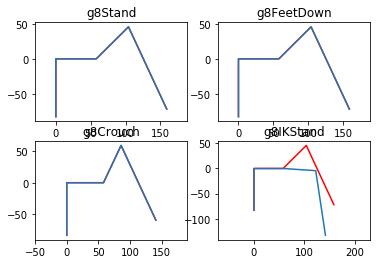

In [7]:
# Lets look at our pre-defined poses' leg orientations
leg_geom, leg1, leg2, leg3, leg4 = gen_numa2_legs()
gait = Gaits(leg_geom, leg1, leg2, leg3, leg4, bodyH)
from mock_hardware import MockBusToWriteList

axbus_position_mock = MockBusToWriteList()
plt.figure()
ax1 = plt.subplot(2,2,1)
poseL1(ax1, gait, axbus_position_mock)
poseL2(ax1, gait, axbus_position_mock)

In [8]:
print("L2", leg2.s2_center, gait.s22pos, (gait.s22pos - leg2.s2_center), leg2.s2_sign*leg_geom.joint2sign*(gait.s22pos - leg2.s2_center)/1024*300)
print("L1", leg1.s2_center, gait.s12pos, (gait.s12pos - leg1.s2_center), leg1.s2_sign*leg_geom.joint2sign*(gait.s12pos - leg1.s2_center)/1024*300)
print(gait.s22pos, gait.s12pos)
54/150*512.

L2 619 632 13 -3.80859375
L1 405 626 221 64.74609375
632 626


184.32

In [9]:
print(gait.L12)
print(gait.L0)

58
135


In [10]:
print(leg2.get_pos_from_angle(0,0,0))
print(leg2.get_pos_from_angle(0,45,-110))

[359, 619, 424, 512]
[359, 466, 799, 512]


In [11]:
(772-619)/1024*300

44.82421875

In [12]:
print(leg2.s1_center)
print(leg2.s2_center)
print(leg2.s3_center)
leg2.get_pos_from_angle(0,0,0,0)

359
619
424


[359, 619, 424, 512]

In [13]:
print(leg4.s1_center)
print(leg4.s2_center)
print(leg4.s3_center)
leg4.get_pos_from_angle(0,0,0,0)

359
619
424


[359, 619, 424, 512]

In [14]:
print(leg1.s1_center)
print(leg1.s2_center)
print(leg1.s3_center)
leg1.get_pos_from_angle(0,0,0,0)

665
405
600


[665, 405, 600, 512]

In [15]:
print("+z, upper", 512 + 35/150*512)
print("+z, lower", 512 + 35/150*512)
print("-z, upper", 512 + -1 * 35/150*512)
print("-z, lower", 512 + -1 * 35/150*512)
"So we use a sign variable per leg that reflects the z axis direction for each servo"

+z, upper 631.4666666666667
+z, lower 631.4666666666667
-z, upper 392.5333333333333
-z, lower 392.5333333333333


'So we use a sign variable per leg that reflects the z axis direction for each servo'